Name: Arijit Roy Chowdhury

Wine Quality Prediction using Binary Classification

Date: 13-06-2022

Email: rc.arijit@gmail.com

# Binary Classification with Outlier Treatment and Multi-Collinearity Treatment

# Import Libraries

In [1]:
import time
import random
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler   # same as preprocessing.scale(data)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import metrics, tree
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from urllib.request import urlopen 
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500) 

In [2]:
# Random State 3 gives the best accuracy. 
# I have used a separate code snippet and varied random state in a for loop from 1 to 500 
# to obtain the value of random state that gives highest testing accuracy
r = 3    

# Read the CSV File and check it's attributes

In [3]:
# Read the CSV File. File path to be modified if executed on a different Machine / OS
df = pd.read_csv('QualityPrediction.csv')
dx = ['Bad', 'Good']

In [4]:
# Check the column names
col_list = list(df.columns)
print(col_list)

# Insights: There are 11 predictor variables and 1 Target variable

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [5]:
df.shape
# Insights: The dataset has 1599 rows and 12 columns

(1599, 12)

In [6]:
df.dtypes
# Insights: There are 11 float type variable columns and all are numeric
# The Target Variable is of Int type but it will be considered as categorical

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [7]:
# Check for Missing Data

total = df.isnull().sum()
percent = (df.isnull().sum()/df.isnull().count())
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

# Insight: There is no missing data in any of the columns

,Total,Percent
fixed acidity,0,0.0
volatile acidity,0,0.0
citric acid,0,0.0
residual sugar,0,0.0
chlorides,0,0.0
free sulfur dioxide,0,0.0
total sulfur dioxide,0,0.0
density,0,0.0
pH,0,0.0
sulphates,0,0.0


In [8]:
# For Quality Column (Target Variable), replace all values < 7 with 0 and all values >= 7 with 1
# Basically if Wine Quality < 7, it will be classified as Bad Wine and if it is >= 7, it will be classified as Good Wine

df['quality'].values[df['quality'] < 7] = 0
df['quality'].values[df['quality'] >= 7] = 1

# Plot Correlation Matrix to visualize the degree of Correlation between variables

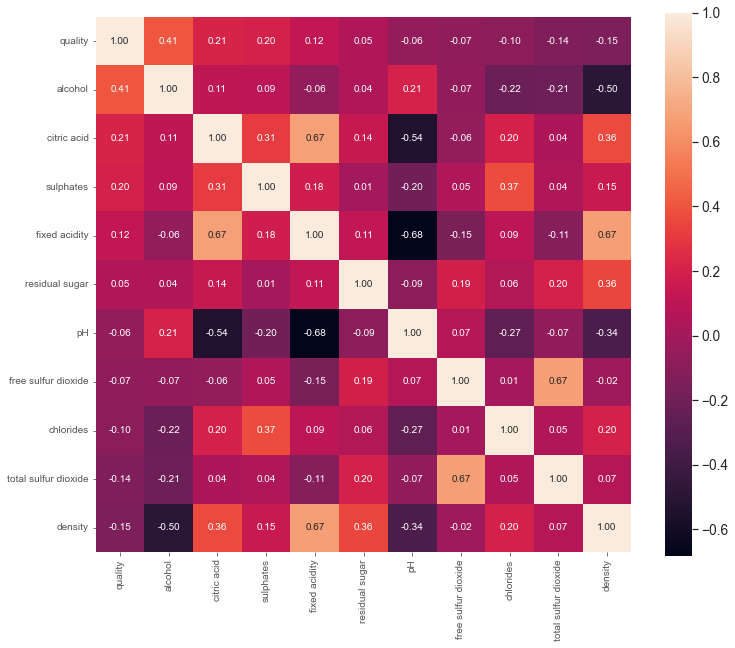

In [9]:
# Create Correlation Matrix
corrmat = df.corr()

# correlation matrix
k = 11 # Number of variables for heatmap
cols = corrmat.nlargest(k, 'quality')['quality'].index

# Correlation Matrix
cm = np.corrcoef(df[cols].values.T)
f, ax = plt.subplots(figsize=(12,10))
sns.set(font_scale=1.25)

# Plot the Heatmap
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [10]:
# Insights on Correlation: 
#        'fixed acidity', 'density' and 'citric acid' are moderately correlated. Drop 'fixed acidity'
#        'free sulfur dioxide' and 'total sulfur dioxide' are moderately correlated. Drop 'free sulfur dioxide'

df = df.drop(['free sulfur dioxide', 'fixed acidity'], axis = 1)

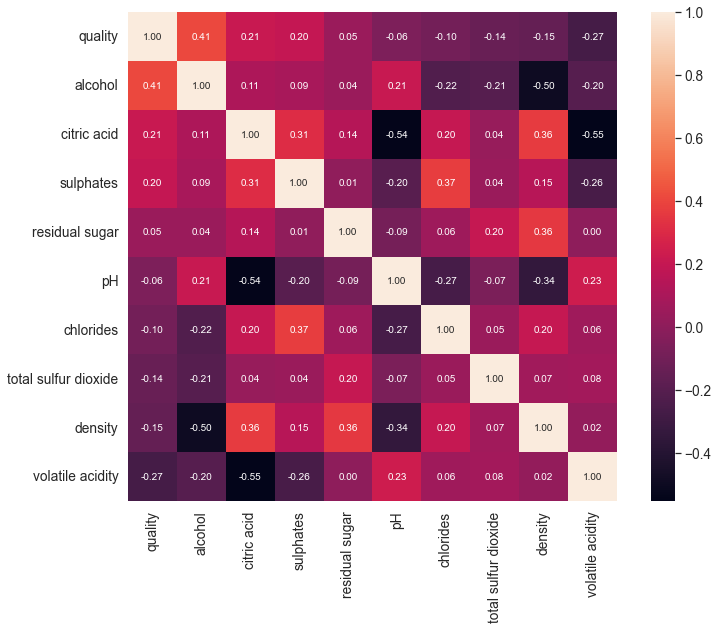

In [11]:
# Create Correlation Matrix again after removal of correlated variables
corrmat = df.corr()

# Correlation matrix
k = 10 # Number of variables for heatmap
cols = corrmat.nlargest(k, 'quality')['quality'].index

# Correlation Matrix
cm = np.corrcoef(df[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)

# Plot the Heatmap
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Outlier Check: Boxplots and Pairplots

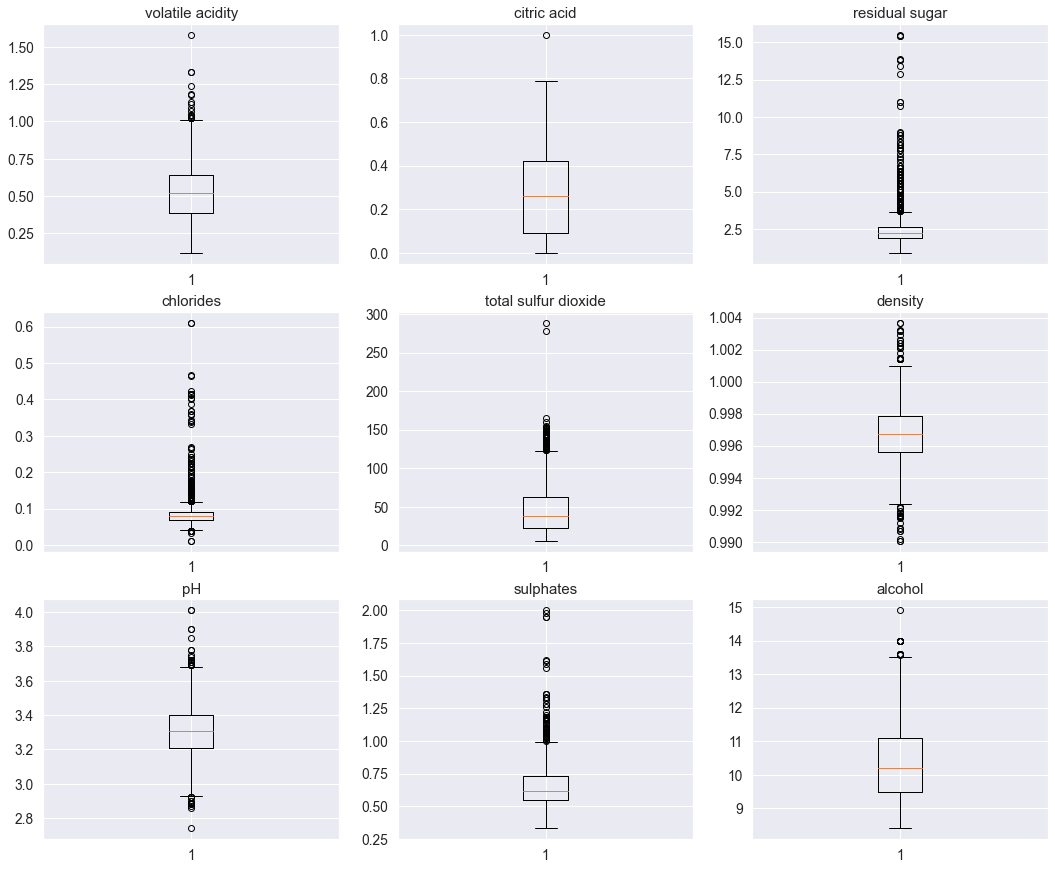

In [12]:
cols1 = list(df.columns)
fig, ax = plt.subplots(3, 3, figsize=(18, 15))
c = 0
for i in range(3):
    for j in range(3):
        ax[i, j].boxplot(df[[cols1[c]]])
        ax[i, j].set_title(cols1[c])
        c=c+1 
plt.show()

# Insights on Outliers: Boxplots shows that most of the variables have outliers. Hence Outlier Treatment is necessary

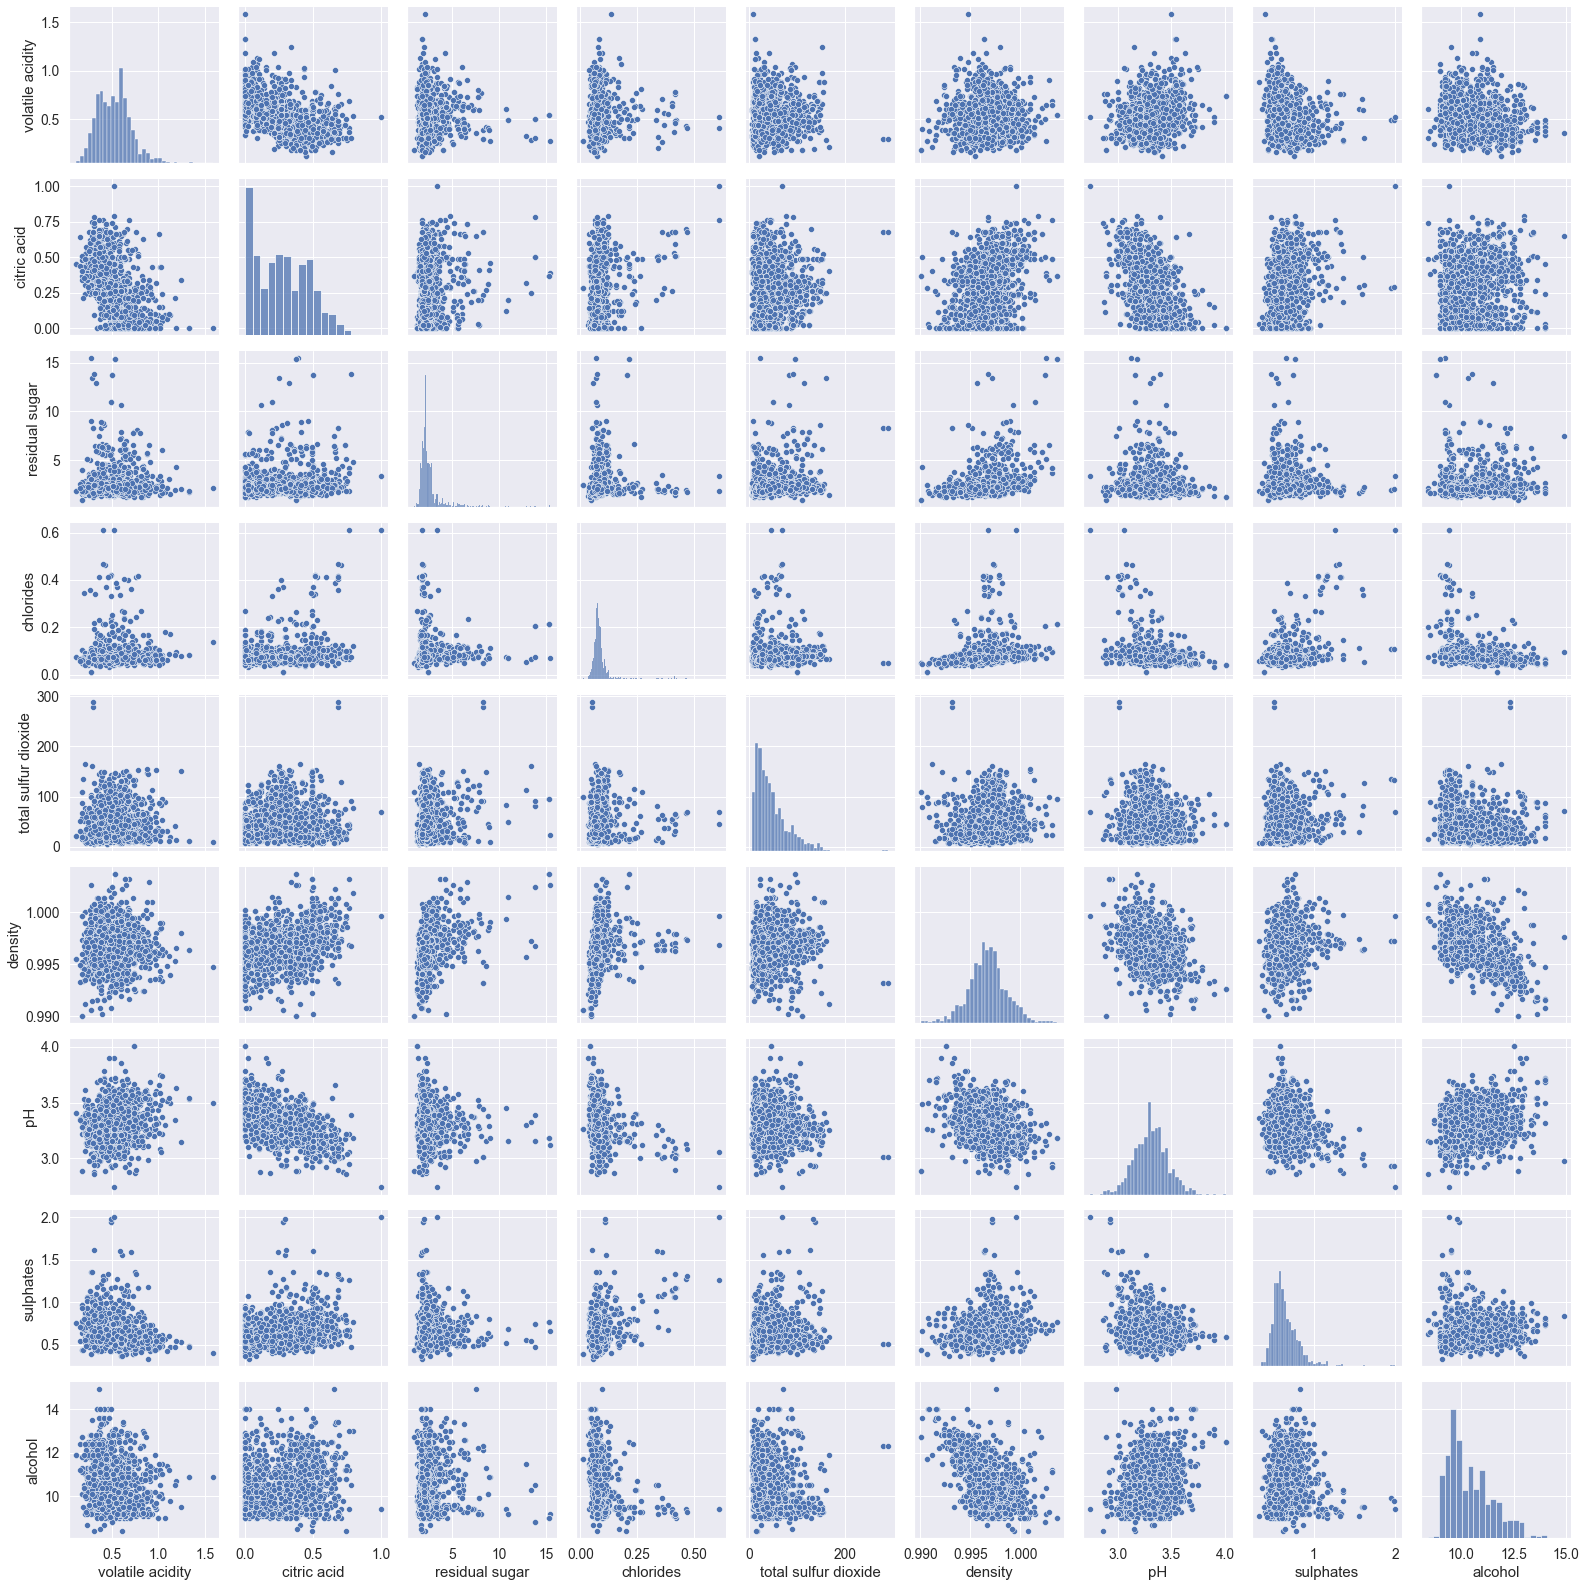

In [13]:
sns.pairplot(df.drop(['quality'], axis = 1))
plt.show()
# Insights on Outliers: Scatter Plots shows that most of the variables have outliers. Hence Outlier Treatment is necessary

In [14]:
# Outlier Treatment:
# Keep only those rows where the Z Score of all columns is < 3. 
# Basically drop all rows where Z Score value of at least 1 column >= 3

df=df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

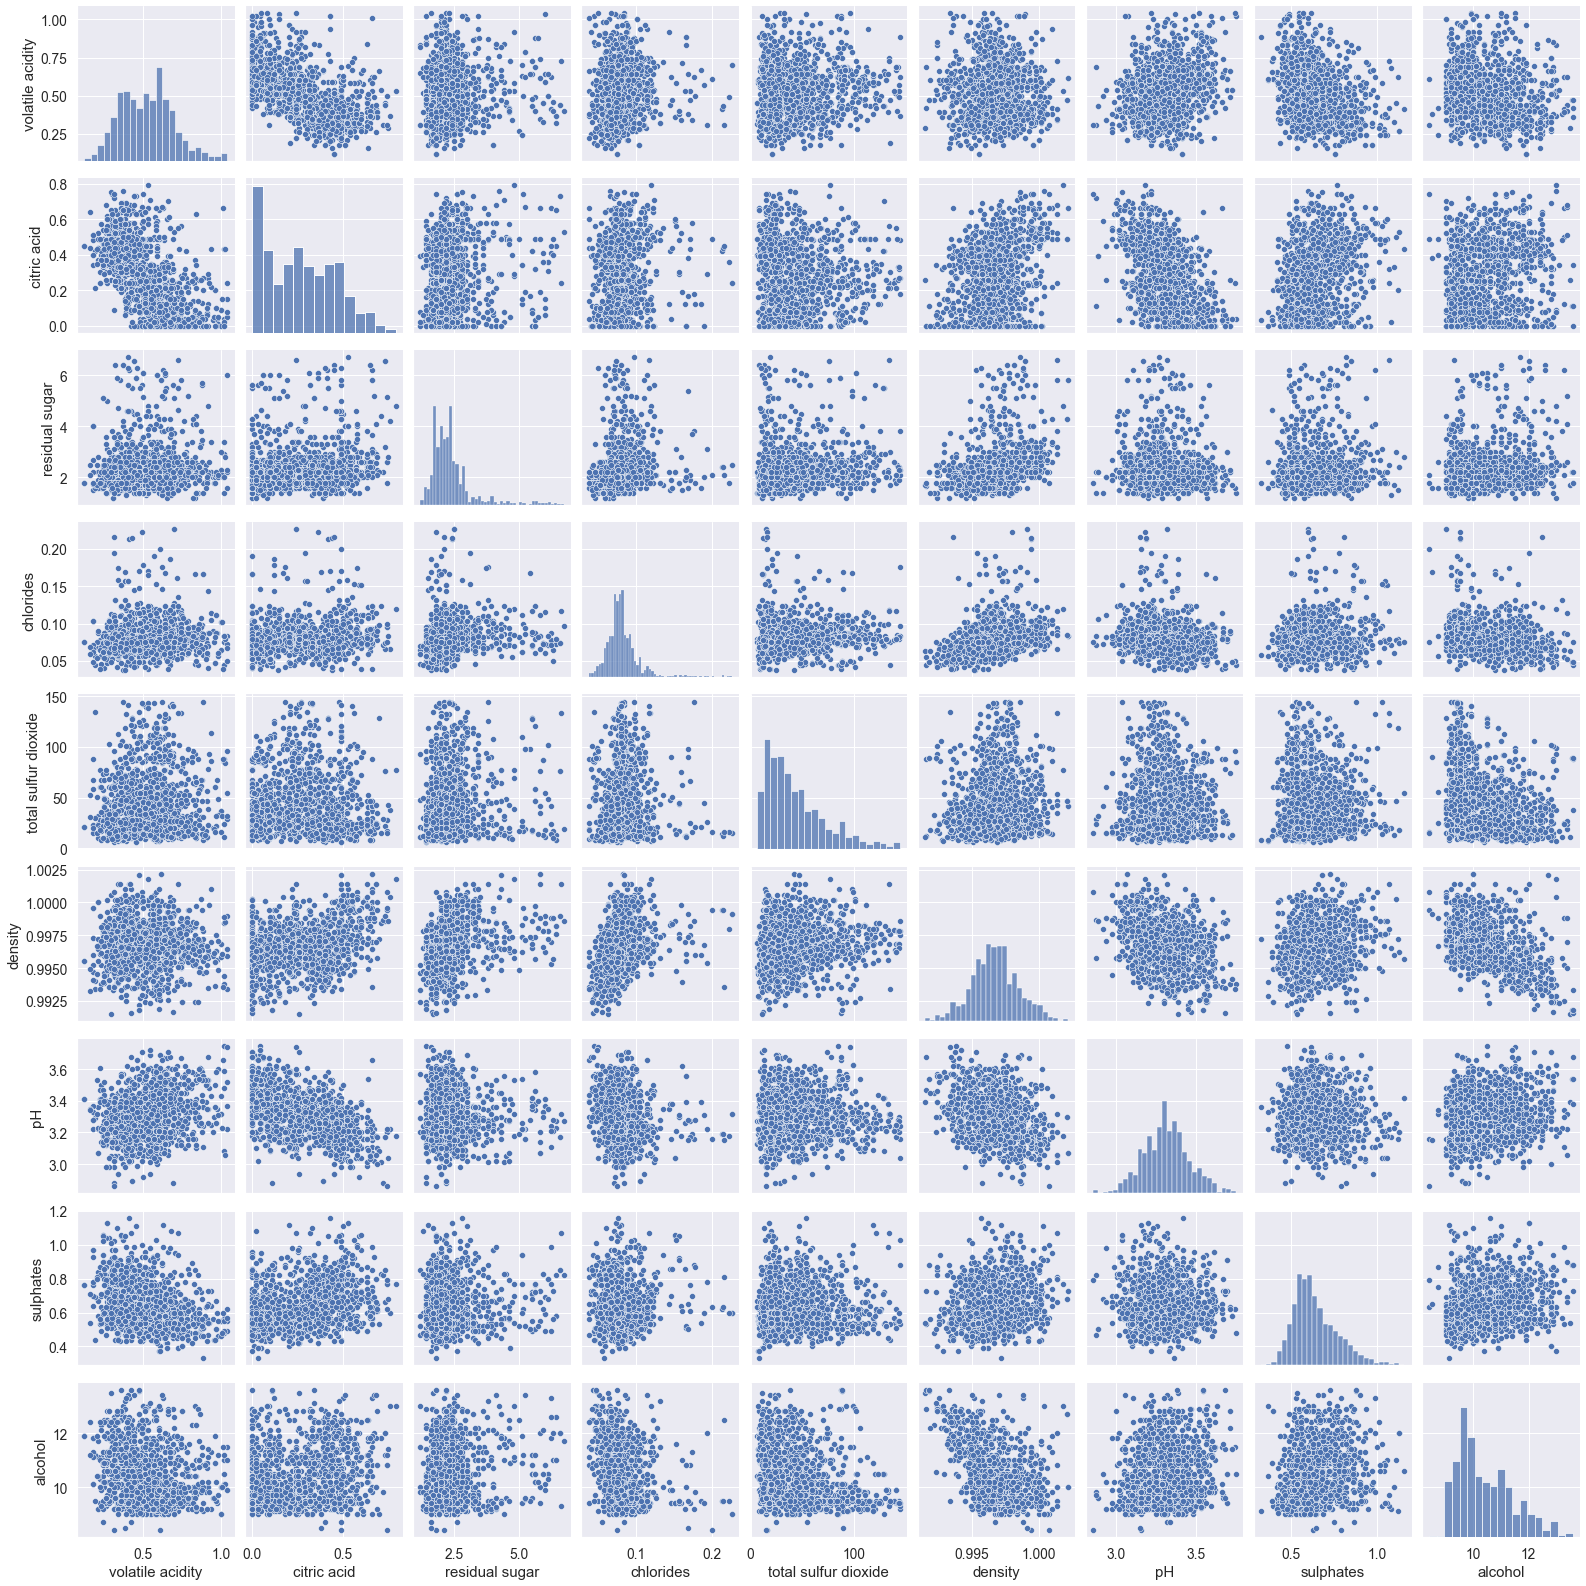

In [15]:
# Check for Outliers again after treating outliers
sns.pairplot(df.drop(['quality'], axis = 1))
plt.show()

# Insights: Outliers are significantly reduced now

In [16]:
# Double check the effect of Outlier Treatment by comparing Mean and Median
# If there is a high difference between mean and median, it may possibily due to the presence of outliers.
# Although there are other reasons as well like if the data is highly skewed at both ends.

col_list = list(df.columns)
median=df.median()
mean=df.mean()

for i in range(0, len(col_list)-1):
    print(col_list[i])
    print("Mean   = ", mean[i].round(1))
    print("Median = ", median[i].round(1), end = '\n\n')
    
# Insights: The gap between Mean and Median has reduced significantly

volatile acidity
Mean   =  0.5
Median =  0.5

citric acid
Mean   =  0.3
Median =  0.2

residual sugar
Mean   =  2.4
Median =  2.2

chlorides
Mean   =  0.1
Median =  0.1

total sulfur dioxide
Mean   =  44.0
Median =  36.0

density
Mean   =  1.0
Median =  1.0

pH
Mean   =  3.3
Median =  3.3

sulphates
Mean   =  0.6
Median =  0.6

alcohol
Mean   =  10.4
Median =  10.2



# Convert the Target Column to Categorical

In [17]:
df['quality'] = pd.Categorical(df.quality)

In [18]:
encoded_df = df.copy(deep = True)
encoded_df_nb = encoded_df.copy(deep = True)

# Feature Scaling / Standardization

In [19]:
# Save the Target Variable "quality" in variable y before standardization as Target Variable should not be standardised
y = encoded_df['quality'].values

In [20]:
cols = list(encoded_df.columns)
l = len(cols)-1
cols = cols[0:l]

#data = encoded_df.iloc[:, 1:].values  
data = encoded_df.drop('quality', axis = 1).values  

#standardize the data to normal distribution
dataset1_standardized = preprocessing.scale(data)
encoded_df1 = pd.DataFrame(dataset1_standardized, columns = cols)    # encoded_df1 is the dataset without the target variable
#encoded_df1.head(20)

In [21]:
# Save the standardised values of variables in x
x = encoded_df1.values

In [22]:
# Split Training and Testing Data in 80:20 ratio
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.2, random_state=r)

In [23]:
# For later use in CART models to calculate Variable Importance. Variable names_index should contain only the 
# names of dependent variables and not the Target Variable "quality" in this case.

names = list(encoded_df.drop('quality', axis = 1).columns)
names_index = names[0:l]

# Function to plot Confusion Matrix

In [24]:
# Function to plot Confusion Matrix. Callable in future from all models

def create_conf_mat(ytest, pred, model_name):
    sns.set(rc = {'figure.figsize':(2,2)})
    if (len(ytest .shape) != len(pred.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (ytest .shape != pred.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = ytest, columns = pred)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
   
        sns.heatmap(test_crosstb, annot=True, fmt='d', cbar=False)
        plt.xlabel('Predicted Values')
        plt.ylabel('Actual Values')
        plt.title(model_name)
        plt.show()

# Function to plot Area Under Curve

In [25]:
# Function to plot AUC (Area Under Curve). Callable in future from all models

def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):

    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'dt': ['Decision Tree', 'darkgreen'],
              'nn': ['Neural Network', 'purple'],
              'svm':['Support Vector Machines', 'blue'],
              'log':['Logistic Regression', 'orange'],
              'nb' :['Naive Bayes Classifier', 'brown']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.2f})'\
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)                          # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

# Function to plot Classification Report

In [26]:
# Function to print Classification Report. Callable in future from all models

def print_class_report(predictions, y_t, target, alg_name):
    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(predictions, y_t, target_names = target))

# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Decision Tree Classifier

In [27]:
model_dt = DecisionTreeClassifier(random_state=r)

# Hyper-Parameter Optimization using GridSearchCV (Cross Validation)

In [28]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Automatically find the best parameters instead of manual hit and try

# np.random.seed(r)
# start = time.time()

# param_dist = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 20],
#               'max_features': ['auto', 'sqrt', 'log2', None],
#               'criterion': ['gini', 'entropy'],
#               'min_samples_split' : [3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 35, 50, 75, 100],
#               'min_samples_leaf' : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

# # n_jobs should be 1 less than number of CPU cores. -1 means all cores
# cv_dt = GridSearchCV(model_dt, cv = 10, param_grid=param_dist, n_jobs = -1)                 

# cv_dt.fit(x_train, y_train)
# print('Best Parameters using grid search: \n', cv_dt.best_params_)
# end = time.time()
# print('Time taken in grid search: {0: .2f}'.format(end - start))

# Decision Tree Classifier Model

In [29]:
# Set best parameters given by grid search CV
model_dt.set_params(max_depth=7 ,
                    criterion="entropy", 
                    min_samples_split=10, 
                    min_samples_leaf=4, 
                    max_features = 'auto')

model_dt.fit(x_train, y_train)

model_dt_score_train = model_dt.score(x_train, y_train)
print("Training score: ", model_dt_score_train)

model_dt_score_test = model_dt.score(x_test, y_test)
print("Testing score: ",model_dt_score_test)

Training score:  0.9297800338409475
Testing score:  0.8885135135135135


# Plot the Decision Tree Structure

In [30]:
# df2 = pd.DataFrame(df.drop(['quality'], axis = 1))
# col_names = list(df2.columns)
# fn = col_names
# cn = ['bad', 'good']

# fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,8), dpi = 300)
# tree.plot_tree(model_dt, feature_names = fn, class_names = cn, filled = True)
# fig.savefig('DecisionTree.jpg')

# Predictions & Evaluations (AUC, Confusion Matrix & Classification Report)

In [31]:
#y_pred_dt = model_dt.predict_proba(x_test)

In [32]:
#predictions = model_dt.predict_proba(x_test)      # Predicts the probability of predictions being wither 0 or 1
y_pred_dt = model_dt.predict(x_test)            # Actual Predictions

In [33]:
accuracy_dt = metrics.accuracy_score(y_test, y_pred_dt)
Precision_dt = metrics.precision_score(y_test, y_pred_dt,average='weighted')
recall_dt = metrics.recall_score(y_test, y_pred_dt,average='weighted')

print("Accuracy:",accuracy_dt)
print("Precision (Weighted Average):",Precision_dt)
print("Recall (Weighted Average):",recall_dt)

Accuracy: 0.8885135135135135
Precision (Weighted Average): 0.8803811419453538
Recall (Weighted Average): 0.8885135135135135


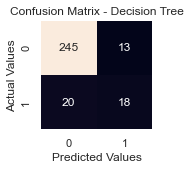

In [34]:
# Call Confusion Matrix Plotting function
# print(confusion_matrix(y_test, predictions))  
create_conf_mat(y_test, y_pred_dt, "Confusion Matrix - Decision Tree")

In [35]:
# Calculate Performance Metrics
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
auc_dt = auc(fpr_dt, tpr_dt)

In [36]:
# Calculate Accuracy and Error Rate

test_error_rate_dt = 1 - model_dt_score_test

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(model_dt_score_test))
print("\nThe test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_dt))

Here is our mean accuracy on the test set:
 0.889

The test error rate for our model is:
  0.1115


In [37]:
class_report = print_class_report(y_test, y_pred_dt, dx, 'Decision Tree')

Classification Report for Decision Tree:
              precision    recall  f1-score   support

         Bad       0.92      0.95      0.94       258
        Good       0.58      0.47      0.52        38

    accuracy                           0.89       296
   macro avg       0.75      0.71      0.73       296
weighted avg       0.88      0.89      0.88       296



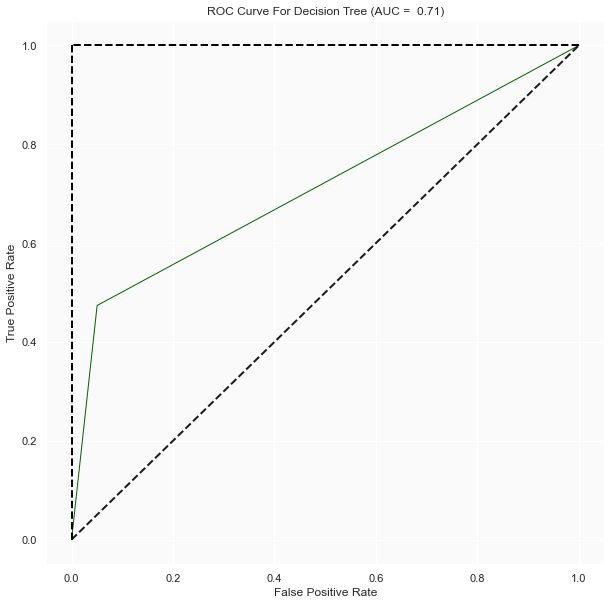

In [38]:
# Call function to plot Area Under Curve (AUC)
plot_roc_curve(fpr_dt, tpr_dt, auc_dt, 'dt')

# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Random Forest Classifier Model

In [39]:
# Split the dataset for training and testing
x1 = encoded_df1.iloc[:, encoded_df1.columns != 'quality']
y1 = encoded_df.iloc[:, encoded_df.columns == 'quality']

x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.3, random_state = r-1)

In [40]:
# Cleaning test sets to avoid future warning messages
y_train1 = y_train1.values.ravel() 
y_test1 = y_test1.values.ravel() 

In [41]:
# Random Forest Classifier: Set the random state for reproducibility
fit_rf = RandomForestClassifier(random_state=r)

# Hyper-Parameter Optimization using GridSearchCV (Cross Validation)

In [42]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Automatically find the best parameters instead of manual hit and try

# np.random.seed(r)
# start = time.time()

# param_dist = {'max_depth': [8, 10, 12, 14, 16, 18, 20],
#               'max_features': ['auto', None],
#               'criterion': ['gini', 'entropy'],
#               'min_samples_split' : [3, 6, 9, 12, 15],
#               'min_samples_leaf' : [3, 6, 9, 12, 15]}

# # Here we can add 
# # 'n_estimator' : [400, 500, 600...], 'min_samples_split' : [5, 10, 15, 20, 30], 'min_samples_leaf' : [2, 3, 4, 5, 7] 
# # but that will consume lot of resources and increase computational time
# # Hence calculate OOB Error Rate and manually put the n_estimator value later
# # n_jobs should be 1 less than number of CPU cores. -1 means all cores
# cv_rf = GridSearchCV(fit_rf, cv = 10, param_grid=param_dist, n_jobs = -1)                 

# cv_rf.fit(x_train1, y_train1)
# print('Best Parameters using grid search: \n', cv_rf.best_params_)
# end = time.time()
# print('Time taken in grid search: {0: .2f}'.format(end - start))

# OOB (Out of Bag) Error Rate

In [43]:
# # OOB: Rows / Columns that are not included in a certain random sample. 
# # The model has no visibility to such records in that particular decision tree being created
# # as they are not exposed to that data

# fit_rf.set_params(warm_start=True, oob_score=True)
 
# min_estimators = 15
# max_estimators = 1000

# error_rate = {}
# for i in range(min_estimators, max_estimators + 1):
#     fit_rf.set_params(n_estimators=i)
#     fit_rf.fit(x_train1, y_train1)
#     oob_error = 1 - fit_rf.oob_score_
#     error_rate[i] = oob_error
    
# # Convert dictionary to a pandas series for easy plotting 
# oob_series = pd.Series(error_rate)
    
# # Insights: Stable n_estimator is found to be around 202 from the OOB plot

In [44]:
# fig, ax = plt.subplots(figsize=(15, 6))

# ax.set_facecolor('#fafafa')
# oob_series.plot(kind='line',color = 'red')
# plt.xlabel('n_estimators')
# plt.ylabel('OOB Error Rate')
# plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 500 trees)')

In [45]:
# print('OOB Error rate for 350 trees is: {0:.5f}'.format(oob_series[202]))

In [46]:
# Refine the tree via OOB Output for n_estimators
# n_estimators is the number of trees we want to build before taking the maximum voting or averages of predictions
# Set best parameters given by grid search 

fit_rf.set_params(max_depth=13, 
                  criterion="gini", 
                  min_samples_split=5, 
                  min_samples_leaf=2, 
                  max_features = 'auto',
                  n_estimators=202,
                  bootstrap = True,
                  warm_start=False, 
                  oob_score=True)

# Train the Random Forest
fit_rf.fit(x_train1, y_train1)

model_rf_score_train = fit_rf.score(x_train1, y_train1)
print("Training score: ", model_rf_score_train)

model_rf_score_test = fit_rf.score(x_test1, y_test1)
print("Testing score: ",model_rf_score_test)

Training score:  0.988394584139265
Testing score:  0.9211711711711712


# Function to find Variable Importance

In [47]:
def variable_importance(fit):
    """
    Purpose:
    Checks if model is fitted CART model then produces variable importance and respective indices in dictionary.
    Parameters:
    * fit:  Fitted model containing the attribute feature_importances_
    Returns:
    Dictionary containing arrays with importance score and index of columns ordered in descending order of importance.
    """
    try:
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 
        # Captures whether the model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances, 'index': indices}

In [48]:
# Check if the lengths of importances_rf, indices_rf, names_index are same. If not, there might be some error in names_index 
# earlier in the code

var_imp_rf = variable_importance(fit_rf)
importances_rf = var_imp_rf['importance']
indices_rf = var_imp_rf['index']
print("Length of importances_rf : ", len(importances_rf))
print("Length of indices_rf     : ", len(indices_rf))
print("Length of names_index    : ", len(names_index))

Length of importances_rf :  9
Length of indices_rf     :  9
Length of names_index    :  9


In [49]:
def print_var_importance(importance, indices, name_index):
    print("Feature ranking:")
    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}".format(f + 1,names_index[indices[i]],importance[indices[f]]))

In [50]:
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'alcohol' has a Mean Decrease in Impurity of 0.20635
2. The feature 'sulphates' has a Mean Decrease in Impurity of 0.16115
3. The feature 'volatile acidity' has a Mean Decrease in Impurity of 0.12762
4. The feature 'citric acid' has a Mean Decrease in Impurity of 0.10791
5. The feature 'density' has a Mean Decrease in Impurity of 0.08941
6. The feature 'total sulfur dioxide' has a Mean Decrease in Impurity of 0.08756
7. The feature 'chlorides' has a Mean Decrease in Impurity of 0.07945
8. The feature 'pH' has a Mean Decrease in Impurity of 0.07380
9. The feature 'residual sugar' has a Mean Decrease in Impurity of 0.06675


In [51]:
def variable_importance_plot(importance, indices, name_index):
    """
    Purpose:
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart was transposed and index would be in incorrect order.
    Parameters:
    * importance: Array returned from feature_importances_ for CART models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest based on feature_importances_
    * name_index: Name of columns included in model
    Returns:
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))
    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])
    fig, ax = plt.subplots(figsize=(12,10))
    #ax.set_axis_bgcolor('#fafafa')
    plt.title('Feature importances for Random Forest Model')
    plt.barh(index, importance_desc, align="center", color = '#875FDB')
    plt.yticks(index, feature_space)
    plt.ylim(-1, 9)                 # Limit should be from -1 to the length of the dataset (i.e. number of dependent variables)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')
    plt.show()

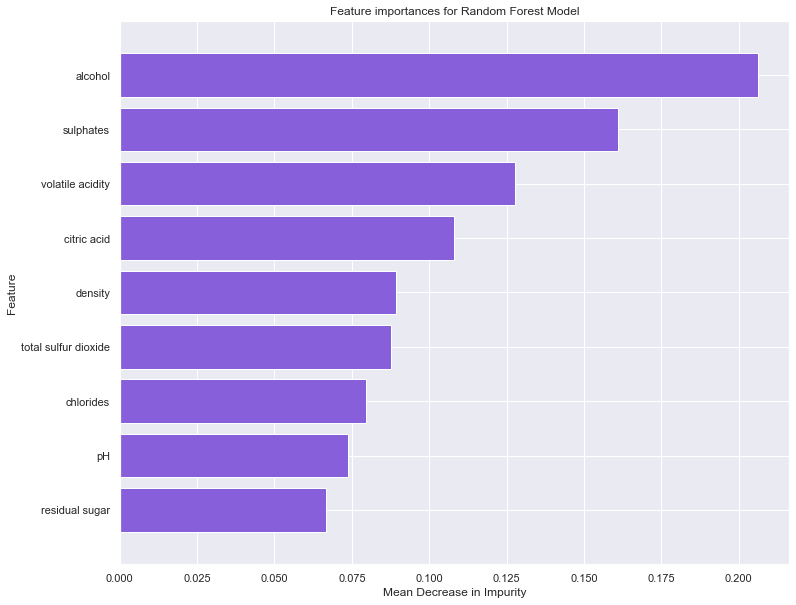

In [52]:
# Most important variables contributing to the Target Variable in descending order of their importance
# The same observations are noticed in EDA as well

variable_importance_plot(importances_rf, indices_rf, names_index)

# Predictions & Evaluations (Confusion Matrix and Classification Report)

In [53]:
y_pred_rf = fit_rf.predict(x_test1)

In [54]:
accuracy_rf = metrics.accuracy_score(y_test1, y_pred_rf)
Precision_rf = metrics.precision_score(y_test1, y_pred_rf,average='weighted')
recall_rf = metrics.recall_score(y_test1, y_pred_rf,average='weighted')

print("Accuracy:",accuracy_rf)
print("Precision (Weighted Average):",Precision_rf)
print("Recall (Weighted Average):",recall_rf)

Accuracy: 0.9211711711711712
Precision (Weighted Average): 0.9143037386280629
Recall (Weighted Average): 0.9211711711711712


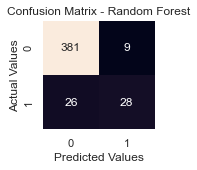

In [55]:
# Call Confusion Matrix Plotting function
# print(confusion_matrix(y_test1, y_pred_rf))  
create_conf_mat(y_test1, y_pred_rf, "Confusion Matrix - Random Forest")

# Accuracy & Error Rate

In [56]:
# Calculate Accuracy and Error Rate

accuracy_rf = fit_rf.score(x_test1, y_test1)
test_error_rate_rf = 1 - accuracy_rf

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_rf))
print("\nThe test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_rf))

Here is our mean accuracy on the test set:
 0.921

The test error rate for our model is:
  0.0788


# Area Under Curve (AUC)

In [57]:
# We grab the second array from the output which corresponds to
# the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class

predictions_prob = fit_rf.predict_proba(x_test1)[:, 1]
fpr2, tpr2, _ = roc_curve(y_test1, predictions_prob, pos_label = 1)

In [58]:
auc_rf = auc(fpr2, tpr2)

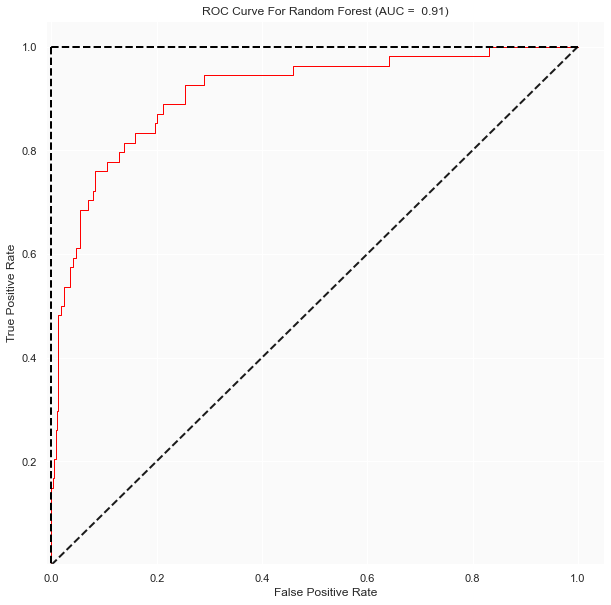

In [59]:
# Call function to plot Area Under Curve (AUC)
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf', xlim=(-0.01, 1.05), ylim=(0.001, 1.05))

In [60]:
# Call functiont to print Classification Report
class_report = print_class_report(y_pred_rf, y_test1, dx, 'Random Forest')

Classification Report for Random Forest:
              precision    recall  f1-score   support

         Bad       0.98      0.94      0.96       407
        Good       0.52      0.76      0.62        37

    accuracy                           0.92       444
   macro avg       0.75      0.85      0.79       444
weighted avg       0.94      0.92      0.93       444



# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# K Nearest Neighbor (KNN)

# Detection of Optimal Value for K Neighnours

In [61]:
# error = []

# # Calculating error for K values between 1 and 40
# for i in range(1, 200):  
#     knn = KNeighborsClassifier(n_neighbors=i)
#     knn.fit(x_train, y_train)
#     pred_i = knn.predict(x_test)
#     error.append(np.mean(pred_i != y_test))
    
# plt.figure(figsize=(16, 6))  
# plt.plot(range(1, 200), error, color='red', linestyle='dashed', marker='o',  
#          markerfacecolor='blue', markersize=8)
# plt.title('Error Rate K Value')  
# plt.xlabel('K Value')  
# plt.ylabel('Mean Error')  
# plt.show()

# # Insights: The value of K for highest accuracy is 76

# K-Nearest Neighbours Classifier

In [62]:
# In the Detection of Optimal Value for K Neighnours plot 76 shows stable result

classifier = KNeighborsClassifier(n_neighbors=76)
classifier.fit(x_train, y_train)  

KNeighborsClassifier(n_neighbors=76)

# Predictions & Evaluations (Confusion Matrix and Classification Report)

In [63]:
y_pred_knn = classifier.predict(x_test)  

In [64]:
accuracy_knn = metrics.accuracy_score(y_test, y_pred_knn)
Precision_knn = metrics.precision_score(y_test, y_pred_knn,average='weighted')
recall_knn = metrics.recall_score(y_test, y_pred_knn,average='weighted')

print("Accuracy:",accuracy_knn)
print("Precision (Weighted Average):",Precision_knn)
print("Recall (Weighted Average):",recall_knn)

Accuracy: 0.8851351351351351
Precision (Weighted Average): 0.8794190742466604
Recall (Weighted Average): 0.8851351351351351


In [65]:
# We grab the second array from the output which corresponds to
# the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class

pred_prob = classifier.predict_proba(x_test)[:, 1]
fpr3, tpr3, _ = roc_curve(y_test, pred_prob, pos_label = 1)

# Accuracy and Error Rate

In [66]:
# Calculate Accuracy and Error Rate

accuracy_knn = classifier.score(x_test, y_test)
test_error_rate_knn = 1 - accuracy_knn

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_knn))
print("\nThe test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_knn))

Here is our mean accuracy on the test set:
 0.885

The test error rate for our model is:
  0.1149


In [67]:
model_knn_score_train = classifier.score(x_train, y_train)
print("Training score: ", model_knn_score_train)

model_knn_score_test = classifier.score(x_test, y_test)
print("Testing score: ",model_knn_score_test)

Training score:  0.8756345177664975
Testing score:  0.8851351351351351


In [68]:
auc_knn = auc(fpr3, tpr3)

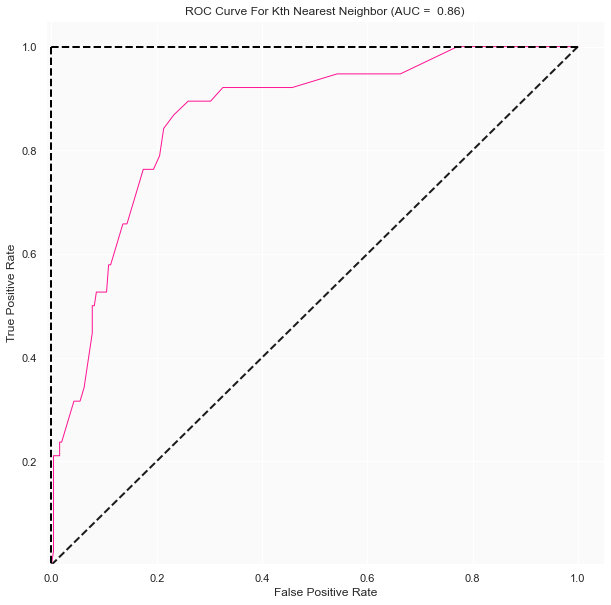

In [69]:
# Call function to plot Area Under Curve (AUC)
plot_roc_curve(fpr3, tpr3, auc_knn, 'knn', xlim=(-0.01, 1.05), ylim=(0.001, 1.05))

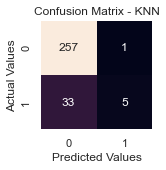

In [70]:
# Call function to plot Confusion Matrix
# print(confusion_matrix(y_test, y_pred_knn))  
conf_mat = create_conf_mat(y_test, y_pred_knn, "Confusion Matrix - KNN")

In [71]:
# Print Classification Report:

class_report = print_class_report(y_pred_knn, y_test, dx, 'K Nearest Neighbor')
# f1 Score = 2 * (precision * recall)/ (precision + recall) ie how good my model is in predicting 1 as 1 and 0 as 0

Classification Report for K Nearest Neighbor:
              precision    recall  f1-score   support

         Bad       1.00      0.89      0.94       290
        Good       0.13      0.83      0.23         6

    accuracy                           0.89       296
   macro avg       0.56      0.86      0.58       296
weighted avg       0.98      0.89      0.92       296



# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Support Vector Machines (SVM)

# Kernel Parameter

In [72]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Linear Kernel:
# svc=SVC(kernel='linear')
# svc.fit(x_train,y_train)
# y_pred_svm=svc.predict(x_test)
# print('\nAccuracy Score for Linear Kernel: ', metrics.accuracy_score(y_test,y_pred_svm))

# # Polynomial Kernel:
# svc=SVC(kernel='poly')
# svc.fit(x_train,y_train)
# y_pred_svm=svc.predict(x_test)
# print('Accuracy Score for Polynomial Kernel: ', metrics.accuracy_score(y_test,y_pred_svm))

# # rbf Kernel:
# svc=SVC(kernel='rbf')
# svc.fit(x_train,y_train)
# y_pred_svm=svc.predict(x_test)
# print('Accuracy Score for rbf Kernel: ', metrics.accuracy_score(y_test,y_pred_svm))

# # sigmoid Kernel:
# svc=SVC(kernel='sigmoid')
# svc.fit(x_train,y_train)
# y_pred_svm=svc.predict(x_test)
# print('Accuracy Score for sigmoid Kernel: ', metrics.accuracy_score(y_test,y_pred_svm))

# # Insights: 'rbf' kernel gives the best accuracy

# Optimizing Hyper Parameter C

In [73]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Optimizing the HyperParameter C

# C_range=list(range(1,100))
# acc_score=[]
# for c in C_range:
#     svc = SVC(kernel='rbf', C=c)
#     scores = cross_val_score(svc, x, y, cv=10, scoring='accuracy', n_jobs = -1)
#     acc_score.append(scores.mean())
# print(acc_score)
# ind = acc_score.index(max(acc_score))
# print("\nOptimal Integer Value of C ~", C_range[ind])

In [74]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)

# C_values=list(range(1,100))
# plt.figure(figsize = (20,6))
# plt.plot(C_values,acc_score)
# plt.xticks(np.arange(0,101,2))
# plt.xlabel('Value of C for SVC')
# plt.ylabel('Cross-Validated Accuracy')

In [75]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Find the exact value of C up to 1 place of decimal

# C_range=list(np.arange(0,2,0.1))
# acc_score=[]
# for c in C_range:
#     svc = SVC(kernel='linear', C=c)
#     scores = cross_val_score(svc, x, y, cv=10, scoring='accuracy', n_jobs = -1)
#     acc_score.append(scores.mean())
# #print(acc_score)    


# # plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)

# C_values=list(np.arange(0,2,0.1))
# plt.figure(figsize = (20,6))
# plt.plot(C_values,acc_score)
# plt.xticks(np.arange(0,2,0.2))
# plt.xlabel('Value of C for SVC ')
# plt.ylabel('Cross-Validated Accuracy')

# # Insights: Optimal Vaue of C = 0.2

# Optimizing Hyper Parameter Gamma

In [76]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Optimizing the HyperParameter Gamma

# gamma_range=[0.0001,0.001,0.01,0.1,1,2,3]
# acc_score=[]
# for g in gamma_range:
#     svc = SVC(kernel='rbf', gamma=g)
#     scores = cross_val_score(svc, x, y, cv=10, scoring='accuracy', n_jobs = -1)
#     acc_score.append(scores.mean())
# print(acc_score)  


# # plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)

# gamma_range=[0.0001,0.001,0.01,0.1,1,2,3]
# plt.figure(figsize = (20,6))
# plt.plot(gamma_range,acc_score)
# plt.xlabel('Value of gamma for SVC ')
# plt.xticks(np.arange(0,3,0.2))
# plt.ylabel('Cross-Validated Accuracy')

# Hyper-Parameter Optimization using GridSearchCV (Cross Validation)

In [77]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Automatically find the best parameters instead of manual hit and try

# svm_model= SVC()
# tuned_parameters = {'C': (np.arange(0,2,0.05)), 
#                     'gamma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07], 
#                     'kernel':['rbf'], 
#                     'degree': [1, 2]}

# fit_svm = GridSearchCV(svm_model, tuned_parameters, cv=10, scoring='accuracy', n_jobs = -1)
# fit_svm.fit(x_train, y_train)
# print("Accuracy: ", fit_svm.best_score_)
# print("Parameters: ", fit_svm.best_params_)

# # Accuracy:  0.8891824526420737
# # Parameters:  {'C': 1.7000000000000002, 'degree': 1, 'gamma': 0.07, 'kernel': 'rbf'}

# Support Vector Machine (SVM) Classifier

In [78]:
svm_model= SVC(probability=True)
tuned_parameters = {'C': [1.7] , 'kernel': ['rbf'], 'gamma': [0.07], 'degree': [1]}

fit_svm = GridSearchCV(svm_model, tuned_parameters, cv=10, scoring='accuracy', n_jobs = -1)
fit_svm.fit(x_train, y_train)
print("Accuracy: ", fit_svm.best_score_)
print("Parameters: ", fit_svm.best_params_)

Accuracy:  0.8891824526420737
Parameters:  {'C': 1.7, 'degree': 1, 'gamma': 0.07, 'kernel': 'rbf'}


# Predictions & Evaluations (Confusion Matrix and Classification Report)

In [79]:
y_pred_svm = fit_svm.predict(x_test)

In [80]:
accuracy_svm = metrics.accuracy_score(y_test, y_pred_svm)
Precision_svm = metrics.precision_score(y_test, y_pred_svm,average='weighted')
recall_svm = metrics.recall_score(y_test, y_pred_svm,average='weighted')

print("Accuracy:",accuracy_svm)
print("Precision (Weighted Average):",Precision_svm)
print("Recall (Weighted Average):",recall_svm)

Accuracy: 0.8783783783783784
Precision (Weighted Average): 0.855153714865945
Recall (Weighted Average): 0.8783783783783784


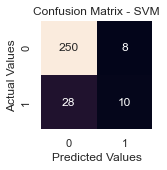

In [81]:
# Call function to plot Confusion Matrix
# print(confusion_matrix(y_test, y_pred_svm))  
conf_mat = create_conf_mat(y_test, y_pred_svm, "Confusion Matrix - SVM")

# Accuracy and Error Rate

In [82]:
# We grab the second array from the output which corresponds to
# the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class

pred_prob = fit_svm.predict_proba(x_test)[:, 1]
fpr4, tpr4, _ = roc_curve(y_test, pred_prob, pos_label = 1)

In [83]:
# Calculate Accuracy and Error Rate

accuracy_svm = fit_svm.score(x_test, y_test)
test_error_rate_svm = 1 - accuracy_svm

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_svm))
print("\nThe test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_svm))

Here is our mean accuracy on the test set:
 0.878

The test error rate for our model is:
  0.1216


In [84]:
model_svm_score_train = fit_svm.score(x_train, y_train)
print("Training score: ", model_svm_score_train)

model_svm_score_test = fit_svm.score(x_test, y_test)
print("Testing score: ",model_svm_score_test)

Training score:  0.9027072758037225
Testing score:  0.8783783783783784


# Area Under Curve (AUC)

In [85]:
auc_svm = auc(fpr4, tpr4)

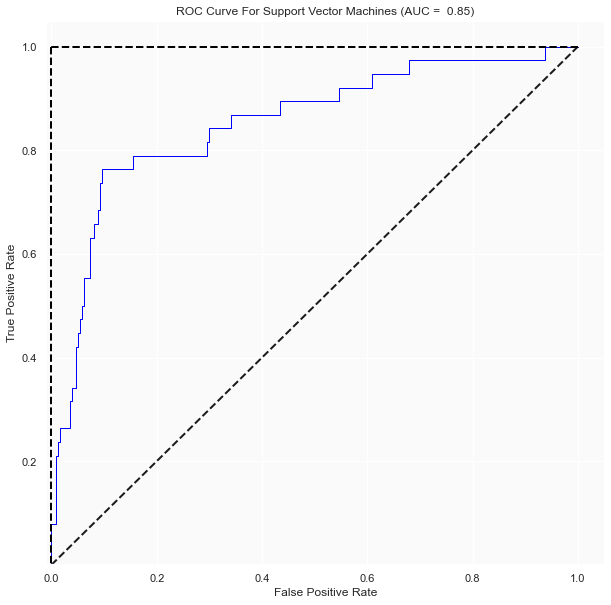

In [86]:
# Call function to plot Area Under Curve (AUC)
plot_roc_curve(fpr4, tpr4, auc_svm, 'svm', xlim=(-0.01, 1.05), ylim=(0.001, 1.05))

In [87]:
# Print Classification Report:

class_report = print_class_report(y_pred_svm, y_test, dx, 'Support Vector Machines')
# f1 Score = 2 * (precision * recall)/ (precision + recall) ie how good my model is in predicting 1 as 1 and 0 as 0

Classification Report for Support Vector Machines:
              precision    recall  f1-score   support

         Bad       0.97      0.90      0.93       278
        Good       0.26      0.56      0.36        18

    accuracy                           0.88       296
   macro avg       0.62      0.73      0.64       296
weighted avg       0.93      0.88      0.90       296



# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Logistic Regression Classifier

In [88]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# fit the model with data
logreg.fit(x_train,y_train)

LogisticRegression()

# Predictions & Evaluations (Confusion Matrix and Classification Report)

In [89]:
y_pred_log=logreg.predict(x_test)

In [90]:
accuracy_log = metrics.accuracy_score(y_test, y_pred_log)
Precision_log = metrics.precision_score(y_test, y_pred_log,average='weighted')
recall_log = metrics.recall_score(y_test, y_pred_log,average='weighted')

print("Accuracy:",accuracy_log)
print("Precision (Weighted Average):",Precision_log)
print("Recall (Weighted Average):",recall_log)

Accuracy: 0.8783783783783784
Precision (Weighted Average): 0.8569623971797885
Recall (Weighted Average): 0.8783783783783784


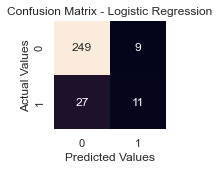

In [91]:
# Call function to plot Confusion Matrix
# print(confusion_matrix(y_test, y_pred_log))  
conf_mat_log = create_conf_mat(y_test, y_pred_log, "Confusion Matrix - Logistic Regression")

# Accuracy & Error Rate

In [92]:
accuracy_log = metrics.accuracy_score(y_test, y_pred_log)
Precision_log = metrics.precision_score(y_test, y_pred_log)
recall_log = metrics.recall_score(y_test, y_pred_log)

print("Accuracy:",accuracy_log)
print("Precision:",Precision_log)
print("Recall:",recall_log)

Accuracy: 0.8783783783783784
Precision: 0.55
Recall: 0.2894736842105263


In [93]:
model_log_score_train = logreg.score(x_train, y_train)
print("Training score: ", model_log_score_train)

model_log_score_test = logreg.score(x_test, y_test)
print("Testing score: ",model_log_score_test)

Training score:  0.8857868020304569
Testing score:  0.8783783783783784


# Area Under Curve (AUC)

In [94]:
y_pred_proba_log = logreg.predict_proba(x_test)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test,  y_pred_proba_log)
auc_log = metrics.roc_auc_score(y_test, y_pred_proba_log)

In [95]:
auc_log = auc(fpr5, tpr5)

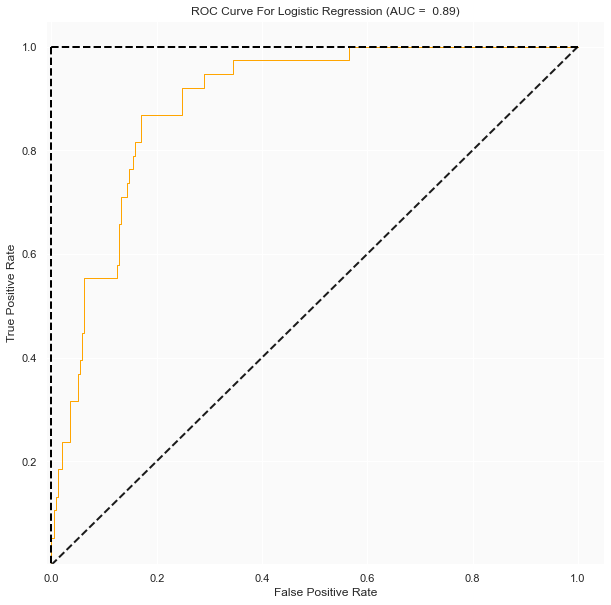

In [96]:
# Call function to plot Area Under Curve (AUC)
plot_roc_curve(fpr5, tpr5, auc_log, 'log', xlim=(-0.01, 1.05), ylim=(0.001, 1.05))

In [97]:
# Print Classification Report:

class_report = print_class_report(y_pred_log, y_test, dx, 'Logistic Regression')
# f1 Score = 2 * (precision * recall)/ (precision + recall) ie how good my model is in predicting 1 as 1 and 0 as 0

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         Bad       0.97      0.90      0.93       276
        Good       0.29      0.55      0.38        20

    accuracy                           0.88       296
   macro avg       0.63      0.73      0.66       296
weighted avg       0.92      0.88      0.90       296



# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Naive Bayes Classifier (for Numerical Data)

In [98]:
xNB = encoded_df_nb.iloc[:, encoded_df_nb.columns != 'quality']
yNB = encoded_df_nb.iloc[:, encoded_df_nb.columns == 'quality']

X_trainNB, X_testNB, y_trainNB, y_testNB = train_test_split(xNB, yNB, test_size=0.2, random_state=r)

In [99]:
# Cleaning test sets to avoid future warning messages
y_trainNB = y_trainNB.values.ravel() 
y_testNB = y_testNB.values.ravel() 

In [100]:
nb = MultinomialNB()
nb.fit(X_trainNB, y_trainNB)

MultinomialNB()

# Predictions & Evaluations (Confusion Matrix and Classification Report)

In [101]:
y_pred_nb = nb.predict(X_testNB)

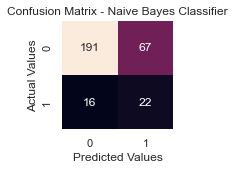

In [102]:
# Call function to plot Confusion Matrix
# print(confusion_matrix(y_testNB, y_pred_nb))  
conf_mat_NB = create_conf_mat(y_testNB, y_pred_nb, "Confusion Matrix - Naive Bayes Classifier")

# Accuracy and Error Rate

In [103]:
# We grab the second array from the output which corresponds to
# the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class

pred_prob_NB = nb.predict_proba(X_testNB)[:, 1]

fpr6, tpr6, _ = roc_curve(y_testNB, pred_prob_NB, pos_label = 1)

In [104]:
# Calculate Accuracy and Error Rate

accuracy_NB = nb.score(X_testNB, y_testNB)
test_error_rate_NB = 1 - accuracy_NB

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_NB))
print("\nThe test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_NB))

Here is our mean accuracy on the test set:
 0.720

The test error rate for our model is:
  0.2804


In [105]:
accuracy_nb = metrics.accuracy_score(y_testNB, y_pred_nb)
Precision_nb = metrics.precision_score(y_testNB, y_pred_nb)
recall_nb = metrics.recall_score(y_testNB, y_pred_nb)

print("Accuracy:",accuracy_nb)
print("Precision:",Precision_nb)
print("Recall:",recall_nb)

Accuracy: 0.7195945945945946
Precision: 0.24719101123595505
Recall: 0.5789473684210527


In [106]:
model_nb_score_train = nb.score(X_trainNB, y_trainNB)
print("Training score: ", model_nb_score_train)

model_nb_score_test = nb.score(X_testNB, y_testNB)
print("Testing score: ",model_nb_score_test)

Training score:  0.6996615905245347
Testing score:  0.7195945945945946


# Area Under Curve (AUC)

In [107]:
y_pred_proba_NB = nb.predict_proba(X_testNB)[::,1]
auc_NB = metrics.roc_auc_score(y_testNB, y_pred_proba_NB)
auc_NB

0.7268461852305182

In [108]:
auc_NB = auc(fpr6, tpr6)
auc_NB

0.7268461852305182

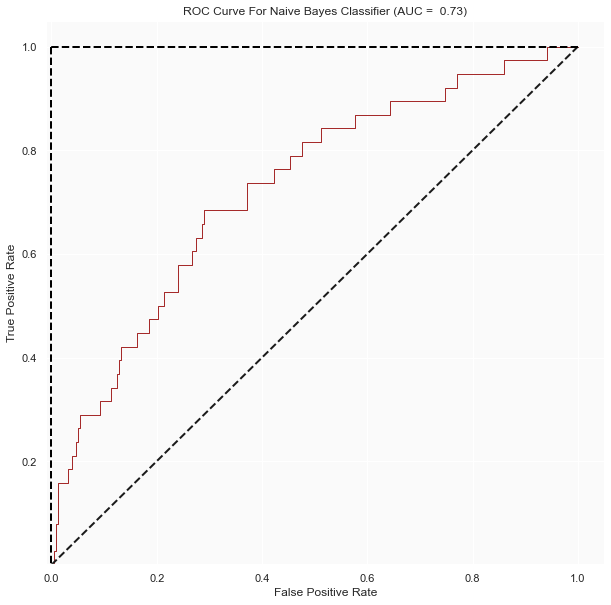

In [109]:
# Call function to plot Area Under Curve (AUC)
plot_roc_curve(fpr6, tpr6, auc_NB, 'nb', xlim=(-0.01, 1.05), ylim=(0.001, 1.05))

In [110]:
# Print Classification Report:

class_report = print_class_report(y_pred_nb, y_testNB, dx, 'Naive Bayes Classifier')
# f1 Score = 2 * (precision * recall)/ (precision + recall) ie how good my model is in predicting 1 as 1 and 0 as 0

Classification Report for Naive Bayes Classifier:
              precision    recall  f1-score   support

         Bad       0.74      0.92      0.82       207
        Good       0.58      0.25      0.35        89

    accuracy                           0.72       296
   macro avg       0.66      0.58      0.58       296
weighted avg       0.69      0.72      0.68       296



# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Final Model Comparison:

# Confusion Matrix Comparison Between Models


DECISION TREE:
Mean accuracy on test set:  0.889
Area Under the Curve (AUC):  0.712


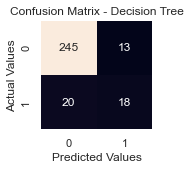


RANDOM FOREST:
Mean accuracy on test set:  0.921
Area Under the Curve (AUC):  0.911


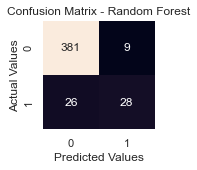


K NEAREST NEIGHBORS:
Mean accuracy on test set:  0.885
Area Under the Curve (AUC):  0.861


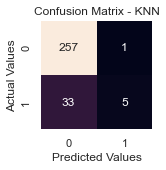


SUPPORT VECTOR MACHINES:
Mean accuracy on test set:  0.878
Area Under the Curve (AUC):  0.853


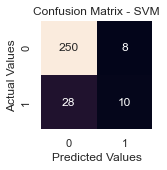


LOGISTIC REGRESSION:
Mean accuracy on test set:  0.878
Area Under the Curve (AUC):  0.892


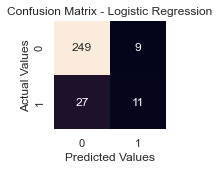


NAIVE BAYES CLASSIFIER:
Mean accuracy on test set:  0.72
Area Under the Curve (AUC):  0.727


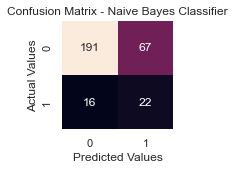

In [111]:
print("\nDECISION TREE:")  
print("Mean accuracy on test set: ", round(model_dt_score_test, 3))
print("Area Under the Curve (AUC): ", round(auc_dt, 3))
create_conf_mat(y_test, y_pred_dt, "Confusion Matrix - Decision Tree")

print("\nRANDOM FOREST:")  
print("Mean accuracy on test set: ", round(accuracy_rf, 3))
print("Area Under the Curve (AUC): ", round(auc_rf, 3))
create_conf_mat(y_test1, y_pred_rf, "Confusion Matrix - Random Forest")

print("\nK NEAREST NEIGHBORS:")  
print("Mean accuracy on test set: ", round(accuracy_knn, 3))
print("Area Under the Curve (AUC): ", round(auc_knn, 3))
create_conf_mat(y_test, y_pred_knn, "Confusion Matrix - KNN")

print("\nSUPPORT VECTOR MACHINES:") 
print("Mean accuracy on test set: ", round(accuracy_svm, 3))
print("Area Under the Curve (AUC): ", round(auc_svm, 3))
create_conf_mat(y_test, y_pred_svm, "Confusion Matrix - SVM")

print("\nLOGISTIC REGRESSION:") 
print("Mean accuracy on test set: ", round(accuracy_log, 3))
print("Area Under the Curve (AUC): ", round(auc_log, 3))
create_conf_mat(y_test, y_pred_log, "Confusion Matrix - Logistic Regression")

print("\nNAIVE BAYES CLASSIFIER:") 
print("Mean accuracy on test set: ", round(accuracy_NB, 3))
print("Area Under the Curve (AUC): ", round(auc_NB, 3))
create_conf_mat(y_testNB, y_pred_nb, "Confusion Matrix - Naive Bayes Classifier")

# INSIGHTS: SVM Model produces the highest accuracy of 95.9%

# Mean Accuracy and AUC Comparison Between Models

# Final Summary of Insights

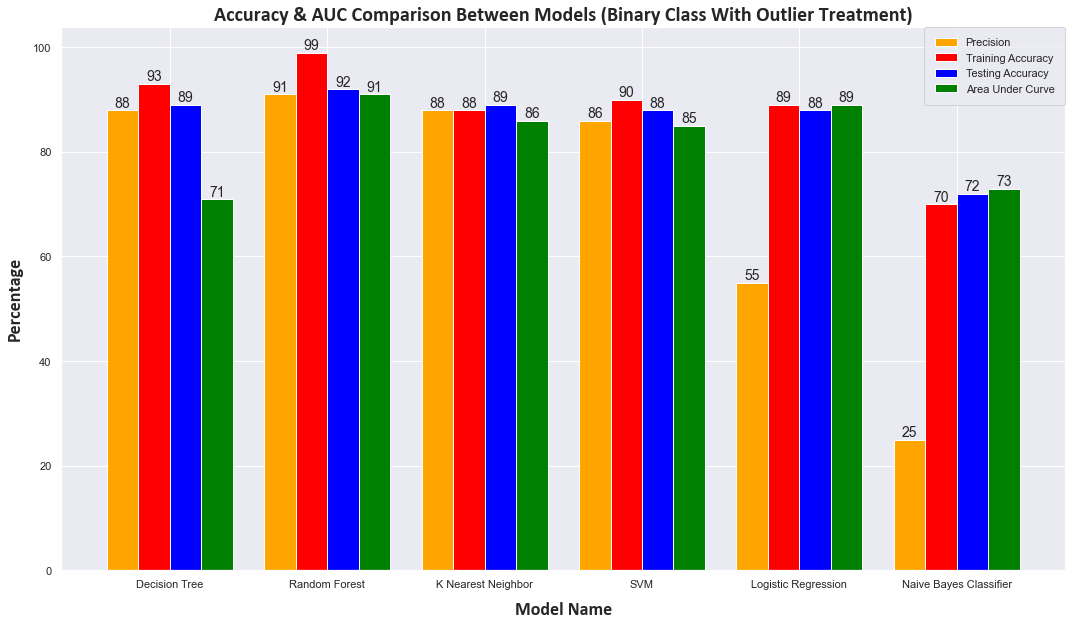

In [112]:
# Create a list of tuples with Mean Test Accuracy of all models:
acc_comparison_test = [('Decision Tree', (model_dt_score_test*100).round()), 
                  ('Random Forest', (model_rf_score_test*100).round()), 
                  ('K Nearest Neighbor', (model_knn_score_test*100).round()), 
                  ('SVM', (model_svm_score_test*100).round()), 
                  ('Logistic Regression', (model_log_score_test*100).round()),
                  ('Naive Bayes Classifier', (model_nb_score_test*100).round())]

# Sort the above list of tuples in descending order of Accuracy:
#acc_comparison.sort(key = lambda x: x[1], reverse = True)
acc_comparison_test = dict(acc_comparison_test)

# Create a list of tuples with Mean Train Accuracy of all models:
acc_comparison_train = [('Decision Tree', (model_dt_score_train*100).round()), 
                  ('Random Forest', (model_rf_score_train*100).round()), 
                  ('K Nearest Neighbor', (model_knn_score_train*100).round()), 
                  ('SVM', (model_svm_score_train*100).round()), 
                  ('Logistic Regression', (model_log_score_train*100).round()),
                  ('Naive Bayes Classifier', (model_nb_score_train*100).round())]

# Sort the above list of tuples in descending order of Accuracy:
#acc_comparison.sort(key = lambda x: x[1], reverse = True)
acc_comparison_train = dict(acc_comparison_train)

# Create a list of tuples with Area Under Curve of all models:
auc_comparison = [('Decision Tree', (auc_dt*100).round()), 
                  ('Random Forest', (auc_rf*100).round()), 
                  ('K Nearest Neighbor', (auc_knn*100).round()), 
                  ('SVM', (auc_svm*100).round()), 
                  ('Logistic Regression', (auc_log*100).round()),
                  ('Naive Bayes Classifier', (auc_NB*100).round())]

# Sort the above list of tuples in descending order of AUC:
#auc_comparison.sort(key = lambda x: x[1], reverse = True)
auc_comparison = dict(auc_comparison)

# Create a list of tuples with Area Under Curve of all models:
prc_comparison = [('Decision Tree', (Precision_dt*100).round()), 
                  ('Random Forest', (Precision_rf*100).round()), 
                  ('K Nearest Neighbor', (Precision_knn*100).round()), 
                  ('SVM', (Precision_svm*100).round()), 
                  ('Logistic Regression', (Precision_log*100).round()),
                  ('Naive Bayes Classifier', (Precision_nb*100).round())]

# Sort the above list of tuples in descending order of AUC:
#auc_comparison.sort(key = lambda x: x[1], reverse = True)
prc_comparison = dict(prc_comparison)

# Plot a bar graph to compare the result
fig = plt.figure(figsize = (18,10))
X_axis = np.arange(len(acc_comparison_test.keys()))  

plt.bar(X_axis - 0.3, prc_comparison.values(), 0.2, color = "Orange", label = "Precision")
plt.bar(X_axis - 0.1, acc_comparison_train.values(), 0.2, color = "Red", label = "Training Accuracy")
plt.bar(X_axis + 0.1, acc_comparison_test.values(), 0.2, color = "Blue", label = "Testing Accuracy")
plt.bar(X_axis + 0.3, auc_comparison.values(), 0.2, color = "Green", label = "Area Under Curve")

# Add Labels
plt.xticks(X_axis, acc_comparison_train.keys())
plt.title("Accuracy & AUC Comparison Between Models (Binary Class With Outlier Treatment)", fontsize=20, fontweight='bold', fontname='calibri')
plt.xlabel("Model Name", fontsize=18, labelpad=12, fontweight='bold', fontname='calibri')
plt.ylabel("Percentage", fontsize=18, labelpad=10, fontweight='bold', fontname='calibri')

lst1 = list(acc_comparison_train.values())
lst2 = list(acc_comparison_test.values())
model_lst = list(acc_comparison_train.keys())
lst3 = list(auc_comparison.values())
lst4 = list(prc_comparison.values())

# Annotate the bars with values
for i in range(len(lst1)):
    plt.annotate(int(lst4[i]), xy=(i-0.3, lst4[i]), ha='center', va='bottom', fontsize = 14)
    plt.annotate(int(lst1[i]), xy=(i-0.1, lst1[i]), ha='center', va='bottom', fontsize = 14)
    plt.annotate(int(lst2[i]), xy=(i+0.1, lst2[i]), ha='center', va='bottom', fontsize = 14)
    plt.annotate(int(lst3[i]), xy=(i+0.3, lst3[i]), ha='center', va='bottom', fontsize = 14)
    
# Add Legend    
plt.legend(loc='upper right', borderpad=1, borderaxespad=0, labelspacing=0.5)

# Insights: 
# Random Forest consistently produces the highest Accuracy and AUC, 
# followed by KNN, Decision Tree, SVM, Logistic Reg and Naive Bayes.
# However the precision for Logistic Regression and Naive Bayes is quite low.
# In case of KNN, Presicion, Training Accuracy, Testing Accuracy and AUC are very close to each other 
# and hence the most preferred algorithm in this case

# Final Summary of Insights

# Binary Classification V/S Multi Class Classification - Which one is better?

In [113]:
# In binary class, it doesn't matter if 3 is classified as 4 or if 4 is classified as 6 
# as both 4 and 6 are less than 7, which means 'BAD WINE', so it's classified correctly. 

# However in Multi Class, if 3 is classified as 4 or if 4 is classified as 6, it means misclassification 
# and hence accuracy is low. 

# Also, having more classes in the Target Variable reduces the sample size for each class
# and hence training data size is smaller

# To conclude, more the number of classes in the target variable, lower the accuracy

# Best Model

In [114]:
# Random Forest consistently produces the highest Accuracy and AUC, 
# followed by KNN, Decision Tree, SVM, Logistic Reg and Naive Bayes.

# However the precision for Logistic Regression and Naive Bayes is quite low. 
# Difference between Training and Testing accuracies is quite high for Random Forest, which indicates overfitting

# In case of KNN, Precision, Training Accuracy, Testing Accuracy and AUC are very close to each other 
# and hence the MOST PREFERRED algorithm in this case